# Imports

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
from livelossplot import PlotLosses

import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from IPython.display import Image
from IPython.display import display, clear_output

import pandas as pd

os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = '' #'true'

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


import seaborn as sns
sns.set_style("darkgrid")

import time
import random

from utilities.utilities import *
from utilities.DHDT import *

# Evaluation

## make_classification

In [ ]:
for i in range(100):
    

    
    
 

In [5]:
identifier_list = [i for i in range(10)]

dataset_dict = {}
model_dict = {}

scores_dict = {}

for identifier in tqdm(identifier_list, desc='dataset loop'):
    
    print('_________________________________________________________________________________________________________________')   
    
    dataset_dict[identifier] = {}
    model_dict[identifier] = {}

    scores_dict[identifier] = {'sklearn': {},
                               'DHDT': {}}
    
    dataset_dict[identifier] = get_preprocessed_dataset(identifier)
    
    X_data, y_data = make_classification(
        n_samples=10_000, 
        n_features=5, 
        n_informative=3, 
        n_redundant=1, 
        random_state=i
    )

    ((dataset_dict[identifier]['X_train'], dataset_dict[identifier]['y_train']), 
     (dataset_dict[identifier]['X_valid'], dataset_dict[identifier]['y_valid']), 
     (dataset_dict[identifier]['X_test'], dataset_dict[identifier]['y_test']), 
     dataset_dict[identifier]['normalizer_list']) = preprocess_data(X_data = X_data, 
                                                                    y_data = y_data,
                                                                    nominal_features = [],
                                                                    ordinal_features = [],
                                                                    random_seed = 42)    

    model_dict[identifier]['sklearn'] = DecisionTreeClassifier(max_depth=3, 
                                                               random_state=42)

    model_dict[identifier]['sklearn'].fit(dataset_dict[identifier]['X_train'], 
                                          dataset_dict[identifier]['y_train'])

    scores_dict[identifier]['sklearn']['accuracy'] = model_dict[identifier]['sklearn'].score(dataset_dict[identifier]['X_test'], 
                                                                                             dataset_dict[identifier]['y_test'])



    model_dict[identifier]['DHDT'] = DHDT(depth=3,
                                             number_of_variables = dataset_dict[identifier]['X_train'].shape[1],
                                             learning_rate=1e-3,
                                             squeeze_factor = 1,
                                             loss='binary_crossentropy',#'binary_crossentropy',
                                             optimizer='rmsprop',
                                             random_seed=40,
                                             verbosity=0)

    scores_dict[identifier]['history'] = model_dict[identifier]['DHDT'].fit(dataset_dict[identifier]['X_train'], 
                                                                          dataset_dict[identifier]['y_train'], 
                                                                          batch_size=512, 
                                                                          epochs=1_000, 
                                                                          early_stopping_epochs=50, 
                                                                          valid_data=(dataset_dict[identifier]['X_valid'], dataset_dict[identifier]['y_valid']))

    dataset_dict[identifier]['y_test_dhdt'] = model_dict[identifier]['DHDT'].predict(dataset_dict[identifier]['X_test'])
    scores_dict[identifier]['DHDT']['accuracy'] = accuracy_score(dataset_dict[identifier]['y_test'], np.round(dataset_dict[identifier]['y_test_dhdt']))
    
    print('Test Accuracy Sklearn (' + identifier + ')', scores_dict[identifier]['sklearn']['accuracy'])
    print('Test Accuracy DHDT (' + identifier + ')', scores_dict[identifier]['DHDT']['accuracy'])   
    print('_________________________________________________________________________________________________________________')   

    

dataset loop:   0%|          | 0/100 [00:00<?, ?it/s]

_________________________________________________________________________________________________________________


NameError: name 'dataset_dict' is not defined

In [3]:
model_sklearn = DecisionTreeClassifier(max_depth=3, random_state=42)

model_sklearn.fit(X_train, y_train)

model_sklearn.score(X_test, y_test)

0.89675

KeyboardInterrupt: 

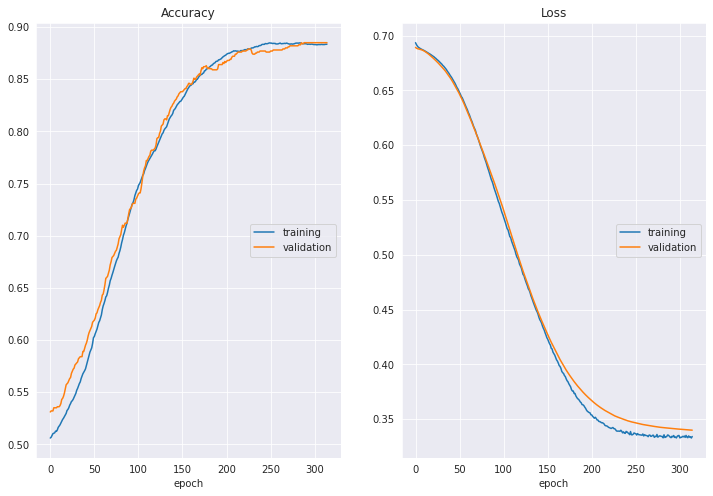

In [4]:
model_dhdt = DHDT(
            depth=3,
            number_of_variables = 5,
            learning_rate=1e-3,
            squeeze_factor = 1,
            loss='binary_crossentropy',#'binary_crossentropy',
            optimizer='rmsprop',
            random_seed=40,
            verbosity=1)

model_dhdt.fit(X_train, 
               y_train, 
               batch_size=512, 
               epochs=1_000, 
               early_stopping_epochs=50, 
               valid_data=(X_valid, y_valid))

y_test_model = model_dhdt.predict(X_test)
score_dhdt = accuracy_score(y_test, np.round(y_test_model))

print('Test Accuracy', score_dhdt)

In [ ]:
plt.figure(figsize=(15,8))
image = model_dhdt.plot()
display(image)

plt.figure(figsize=(15,8))
plot_tree(model_sklearn, fontsize=10) 
plt.show()

## Cervical Cancer

In [ ]:
dataset_dict = {}
model_dict = {}

scores_dict = {}

In [ ]:
identifier = 'Cervical Cancer'

dataset_dict[identifier] = {}
model_dict[identifier] = {}

scores_dict[identifier] = {'sklearn': {},
                           'DHDT': {}}

dataset_dict[identifier] = get_preprocessed_dataset(identifier)

model_dict[identifier]['sklearn'] = DecisionTreeClassifier(max_depth=3, 
                                                           random_state=42)

model_dict[identifier]['sklearn'].fit(dataset_dict[identifier]['X_train'], 
                                      dataset_dict[identifier]['y_train'])

scores_dict[identifier]['sklearn']['accuracy'] = model_dict[identifier]['sklearn'].score(dataset_dict[identifier]['X_test'], 
                                                                                         dataset_dict[identifier]['y_test'])


model_dict[identifier]['DHDT'] = DHDT(depth=3,
                                         number_of_variables = dataset_dict[identifier]['X_train'].shape[1],
                                         learning_rate=1e-3,
                                         squeeze_factor = 1,
                                         loss='binary_crossentropy',#'binary_crossentropy',
                                         optimizer='rmsprop',
                                         random_seed=40,
                                         verbosity=1)

scores_dict[identifier]['history'] = model_dict[identifier]['DHDT'].fit(dataset_dict[identifier]['X_train'], 
                                                                      dataset_dict[identifier]['y_train'], 
                                                                      batch_size=512, 
                                                                      epochs=1_000, 
                                                                      early_stopping_epochs=50, 
                                                                      valid_data=(dataset_dict[identifier]['X_valid'], dataset_dict[identifier]['y_valid']))

dataset_dict[identifier]['y_test_dhdt'] = model_dict[identifier]['DHDT'].predict(dataset_dict[identifier]['X_test'])
scores_dict[identifier]['DHDT']['accuracy'] = accuracy_score(dataset_dict[identifier]['y_test'], np.round(dataset_dict[identifier]['y_test_dhdt']))

print('Test Accuracy Sklearn (' + identifier + ')', scores_dict[identifier]['sklearn']['accuracy'])
print('Test Accuracy DHDT (' + identifier + ')', scores_dict[identifier]['DHDT']['accuracy'])

In [ ]:
identifier_list = ['Cervical Cancer',
                   'Credit Card',
                   'Absenteeism']

dataset_dict = {}
model_dict = {}

scores_dict = {}

for identifier in tqdm(identifier_list, desc='dataset loop'):
    
    print('_________________________________________________________________________________________________________________')   
    
    dataset_dict[identifier] = {}
    model_dict[identifier] = {}

    scores_dict[identifier] = {'sklearn': {},
                               'DHDT': {}}
    
    dataset_dict[identifier] = get_preprocessed_dataset(identifier)

    model_dict[identifier]['sklearn'] = DecisionTreeClassifier(max_depth=3, 
                                                               random_state=42)

    model_dict[identifier]['sklearn'].fit(dataset_dict[identifier]['X_train'], 
                                          dataset_dict[identifier]['y_train'])

    scores_dict[identifier]['sklearn']['accuracy'] = model_dict[identifier]['sklearn'].score(dataset_dict[identifier]['X_test'], 
                                                                                             dataset_dict[identifier]['y_test'])



    model_dict[identifier]['DHDT'] = DHDT(depth=3,
                                             number_of_variables = dataset_dict[identifier]['X_train'].shape[1],
                                             learning_rate=1e-3,
                                             squeeze_factor = 1,
                                             loss='binary_crossentropy',#'binary_crossentropy',
                                             optimizer='rmsprop',
                                             random_seed=40,
                                             verbosity=0)

    scores_dict[identifier]['history'] = model_dict[identifier]['DHDT'].fit(dataset_dict[identifier]['X_train'], 
                                                                          dataset_dict[identifier]['y_train'], 
                                                                          batch_size=512, 
                                                                          epochs=1_000, 
                                                                          early_stopping_epochs=50, 
                                                                          valid_data=(dataset_dict[identifier]['X_valid'], dataset_dict[identifier]['y_valid']))

    dataset_dict[identifier]['y_test_dhdt'] = model_dict[identifier]['DHDT'].predict(dataset_dict[identifier]['X_test'])
    scores_dict[identifier]['DHDT']['accuracy'] = accuracy_score(dataset_dict[identifier]['y_test'], np.round(dataset_dict[identifier]['y_test_dhdt']))
    
    print('Test Accuracy Sklearn (' + identifier + ')', scores_dict[identifier]['sklearn']['accuracy'])
    print('Test Accuracy DHDT (' + identifier + ')', scores_dict[identifier]['DHDT']['accuracy'])   
    print('_________________________________________________________________________________________________________________')   

    

In [ ]:
identifier = "Absenteeism"
plt.figure(figsize=(15,8))
image = model_dict[identifier]['DHDT'].plot(normalizer_list=dataset_dict['normalizer_list'][identifier])
display(image)

plt.figure(figsize=(15,8))
plot_tree(model_dict[identifier]['sklearn'], fontsize=10) 
plt.show()

## Absenteeism